[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nasa/harmony/blob/main/docs/Harmony%20API%20introduction.ipynb)

# Harmony API Introduction

This notebook provides an overview of the capabilities offered through the Harmony API, which supports the [OpenGIS Web Map Service](https://www.ogc.org/standards/wms#overview) and the [OGC API - Coverages](https://github.com/opengeospatial/ogc_api_coverage) specification. The examples below demonstrate synchronous and asynchronous access of several subsetting and reprojection services available from the Harmony/gdal demo service, native data access for data without transformation services, and the WMS map image service.

Authors: Amy Steiker, Patrick Quinn

## Import packages

Most packages below should be included natively with the Anaconda Python distribution, for example, but some may need to install packages like `rasterio` manually using the following example:

In [1]:
# Install prerequisite packages
import sys

# Note you usually need to install gdal outside of Python / pip first. On OSX, brew install gdal
!{sys.executable} -m pip install rasterio OWSLib GDAL matplotlib netCDF4 numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.1 MB/s eta 0:00:00


In [2]:
from urllib import request, parse
from http.cookiejar import CookieJar
from base64 import b64encode
import getpass
import netrc
import requests
import json
import os
import pprint
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import rasterio
from rasterio.plot import show
import numpy as np
import time
from netCDF4 import Dataset
from owslib.wms import WebMapService
from owslib.util import Authentication
%matplotlib inline

## Local directory setup

Specify a local directory where the following Harmony outputs will be saved:

In [3]:
local_dir = './outputs/'
if not os.path.exists(local_dir):
  os.mkdir(local_dir)

## Earthdata Login Authentication

An Earthdata Login account is required to access data from NASA EOSDIS. In order to access data from the Harmony API, you will need to create an account in the Earthdata Login UAT environment. Please visit https://uat.urs.earthdata.nasa.gov to set up an account in this test environment. These accounts, as all Earthdata Login accounts, are free to create and only take a moment to set up.



We need some boilerplate up front to log in to Earthdata Login.  The function below will allow Python scripts to log into any Earthdata Login application programmatically.  To avoid being prompted for
credentials every time you run and also allow clients such as curl to log in, you can add the following
to a `.netrc` (`_netrc` on Windows) file in your home directory:

```
machine uat.urs.earthdata.nasa.gov
    login <your username>
    password <your password>
```

Make sure that this file is only readable by the current user or you will receive an error stating
"netrc access too permissive."

`$ chmod 0600 ~/.netrc`


In [6]:
def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file
    first and if no credentials are found, it prompts for them.

    Valid endpoints include:
        uat.urs.earthdata.nasa.gov - Earthdata Login UAT (Harmony's current default)
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    token = None
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('Please provide your Earthdata Login credentials to allow data access')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (endpoint))
        username = input('syedadnanbukhari63:')
        print('WFnLyGWuQRK6@h8:')
        password = getpass.getpass()

    # Retrieve existing bearer token or generate a new one if none exists
    basic_auth_string = f'{username}:{password}'
    basic_auth_bytes = basic_auth_string.encode('ascii')
    base64_bytes = b64encode(basic_auth_bytes)
    base64_basic_auth = base64_bytes.decode('ascii')
    try:
        token_response = requests.get(f'https://{endpoint}/api/users/tokens', headers={'Authorization': f'Basic {base64_basic_auth}'})
        token_response_json = token_response.json()
        if token_response_json:
            token = token_response_json[0]['access_token']
        else:
            token_response = requests.post(f'https://{endpoint}/api/users/token', headers={'Authorization': f'Basic {base64_basic_auth}'})
            token_response_json = token_response.json()
            token = token_response_json['access_token']
    except:
        print(f'Error: token response: {token_response_json}')

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)
    return token

class BearerToken(requests.auth.AuthBase):
    def __init__(self, token):
        self.token = token
    def __call__(self, r):
        r.headers['Authorization'] = f'Bearer {self.token}'
        return r

Now call the above function to set up Earthdata Login for subsequent requests

In [8]:
bearer_token = setup_earthdata_login_auth('uat.urs.earthdata.nasa.gov')

def submit_request(url):
    status_req = request.Request(url)
    status_req.add_header('Authorization', f'Bearer {bearer_token}')

    # Open the request and read the response
    with request.urlopen(status_req) as response:
        return response.read()

def get_json_response(url):
    response_data = submit_request(url)
    return json.loads(response_data)

Please provide your Earthdata Login credentials to allow data access
Your credentials will only be passed to uat.urs.earthdata.nasa.gov and will not be exposed in Jupyter
syedadnanbukhari63:syedadnanbukhari63
WFnLyGWuQRK6@h8:
··········


## Identify a data collection of interest

A CMR collection ID is needed to request services through Harmony. The collection ID can be determined using the [CMR API](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html). We will query the corresponding ID of a known collection short name, `harmony_example`, which is a Level 3 test collection with transformation services available through Harmony.

In [9]:
params = {
    'short_name': 'harmony_example',
    'version': 2
} # parameter dictionary with known CMR short_name and version

cmr_collections_url = 'https://cmr.uat.earthdata.nasa.gov/search/collections.json'
query_string = parse.urlencode(params)
url = cmr_collections_url + "?" + query_string
cmr_response = request.urlopen(url)
cmr_results = json.loads(cmr_response.read().decode('utf-8'))

collectionlist = [el['id'] for el in cmr_results['feed']['entry']]
harmony_collection_id = collectionlist[0]
print(harmony_collection_id)

C1234088182-EEDTEST


We can also view the `harmony_example` collection metadata to glean more information about the collection:

In [10]:
pprint.pprint(cmr_results)

{'feed': {'entry': [{'association_details': {'services': [{'concept_id': 'S1237980031-EEDTEST'},
                                                          {'concept_id': 'S1257851197-EEDTEST'},
                                                          {'concept_id': 'S1245787332-EEDTEST'},
                                                          {'concept_id': 'S1237974301-EEDTEST'}],
                                             'variables': [{'concept_id': 'V1234088189-EEDTEST'},
                                                           {'concept_id': 'V1234088187-EEDTEST'},
                                                           {'concept_id': 'V1234088190-EEDTEST'},
                                                           {'concept_id': 'V1234088188-EEDTEST'}]},
                     'associations': {'services': ['S1237980031-EEDTEST',
                                                   'S1257851197-EEDTEST',
                                                   'S1245787332-EEDTE

## Determine service availability

We will determine what services are available for the `harmony_example` collection based on the Harmony capabilities endpoint.

In [11]:
capabilities_url = f'https://harmony.uat.earthdata.nasa.gov/capabilities?collectionId={harmony_collection_id}'
capabilities = get_json_response(capabilities_url)
capabilities['services']

[{'name': 'nasa/harmony-gdal-adapter',
  'href': 'https://cmr.uat.earthdata.nasa.gov/search/concepts/S1245787332-EEDTEST',
  'capabilities': {'subsetting': {'temporal': True,
    'shape': True,
    'bbox': True,
    'variable': True,
    'multiple_variable': True},
   'output_formats': ['application/x-netcdf4', 'image/tiff'],
   'reprojection': True}},
 {'name': 'harmony/netcdf-to-zarr',
  'href': 'https://cmr.uat.earthdata.nasa.gov/search/concepts/S1237980031-EEDTEST',
  'capabilities': {'concatenation': True,
   'concatenate_by_default': False,
   'subsetting': {'variable': False},
   'output_formats': ['application/x-zarr']}},
 {'name': 'harmony/service-example',
  'href': 'https://cmr.uat.earthdata.nasa.gov/search/concepts/S1257851197-EEDTEST',
  'capabilities': {'subsetting': {'bbox': True,
    'variable': True,
    'multiple_variable': True},
   'output_formats': ['image/tiff', 'image/png', 'image/gif'],
   'reprojection': True}}]

According to the services.yml, our `harmony_example` collection is associated with the `harmony/gdal` service with bounding box and variable subsetting, reprojection, and reformatting. We will request these services below.

## Explore the Harmony Root URL

Harmony conforms to the OGC API - Coverages specification: https://github.com/opengeospatial/ogc_api_coverages.

The basic Harmony URL convention is as follows:

`<harmony_root>/<collection_id>/ogc-api-coverages/1.0.0/`

We will set the Harmony root path with our chosen collection id:

In [12]:
harmony_root = 'https://harmony.uat.earthdata.nasa.gov'
config = {
    'collection_id': harmony_collection_id,
    'ogc-api-coverages_version': '1.0.0'
}
coverages_root = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/'.format(**config)
print('Request URL', coverages_root)

Request URL https://harmony.uat.earthdata.nasa.gov/C1234088182-EEDTEST/ogc-api-coverages/1.0.0/


This root URL of the coverages endpoint provides links to its child resources:

In [13]:
root_json = get_json_response(coverages_root)
pprint.pprint(root_json)

{'links': [{'href': 'https://harmony.uat.earthdata.nasa.gov/C1234088182-EEDTEST/ogc-api-coverages/1.0.0/',
            'rel': 'self',
            'title': 'this document',
            'type': 'application/json'},
           {'href': 'https://harmony.uat.earthdata.nasa.gov/C1234088182-EEDTEST/ogc-api-coverages/1.0.0/api',
            'rel': 'service-desc',
            'title': 'the API definition',
            'type': 'text/openapi+yaml;version=3.0'},
           {'href': 'https://harmony.uat.earthdata.nasa.gov/C1234088182-EEDTEST/ogc-api-coverages/1.0.0/conformance',
            'rel': 'conformance',
            'title': 'OGC conformance classes implemented by this API',
            'type': 'application/json'},
           {'href': 'https://harmony.uat.earthdata.nasa.gov/C1234088182-EEDTEST/ogc-api-coverages/1.0.0/collections',
            'rel': 'data',
            'title': 'Metadata about the resource collections',
            'type': 'application/json'}]}


The `service_desc` endpoint contains OpenAPI documentation, including information on all supported request parameters:

In [14]:
service_desc = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/api/'.format(**config)
service_txt = submit_request(service_desc)
print(service_txt)

b'openapi: 3.0.1\ninfo:\n  title: Harmony API conforming to OGC API - Coverages\n  description:\n    "Harmony API for requesting coverages for a range of NASA EOSDIS data\n    using thc OGC API - Coverages"\n  version: 1.0.0\nservers:\n  - url: /{cmrCollectionId}/ogc-api-coverages/1.0.0\n    description: Harmony server\n    variables:\n      cmrCollectionId:\n        default: C1234088182-EEDTEST\n        description: The CMR Collection ID for the dataset whose coverage is being accessed\ntags:\n  - name: Capabilities\n    description: Essential characteristics of this API including information about the data.\n  - name: Coverage\n    description: Access to data (coverage).\npaths:\n  /:\n    get:\n      tags:\n        - Capabilities\n      summary: landing page of this API\n      description:\n        The landing page provides links to the API definition, the Conformance\n        statements and the metadata about the coverage data in this dataset.\n      operationId: getLandingPage\n  

The `conformance` endpoint provides the specifications this API conforms to:

In [15]:
conform_desc = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/conformance/'.format(**config)
conform_json = get_json_response(conform_desc)
print(conform_json)

{'conformsTo': ['http://www.opengis.net/spec/ogcapi-common-1/1.0/conf/core', 'http://www.opengis.net/spec/ogcapi-common-1/1.0/conf/collections', 'http://www.opengis.net/spec/ogcapi-coverages-1/1.0/conf/core']}


The `collections` endpoint provides metadata on the resource collections, which include variable metadata from CMR's [UMM-Var schema](https://git.earthdata.nasa.gov/projects/EMFD/repos/unified-metadata-model/browse/variable) in this example:

In [16]:
collections_desc = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/'.format(**config)
collections_json = get_json_response(collections_desc)
pprint.pprint(collections_json)

{'collections': [{'description': 'All variables harmony_example v2 (EEDTEST)',
                  'extent': {'temporal': {'interval': ['1970-06-26T00:00:00.000Z',
                                                       None],
                                          'trs': 'http://www.opengis.net/def/uom/ISO-8601/0/Gregorian'}},
                  'id': 'C1234088182-EEDTEST/all',
                  'itemType': 'Variable',
                  'links': [{'href': 'https://harmony.uat.earthdata.nasa.gov/C1234088182-EEDTEST/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset',
                             'title': 'Perform rangeset request for all'}],
                  'title': 'all harmony_example v2'},
                 {'description': 'Alpha Channel harmony_example v2 (EEDTEST)',
                  'extent': {'temporal': {'interval': ['1970-06-26T00:00:00.000Z',
                                                       None],
                                          'trs': 'http://www.openg

## Access native data without transformation services

For EOSDIS collections without associated Harmony transformation services, the Harmony API can still be utilized to access data through the provided data access links. Before we request services for `harmony_example`, We will use `MYD13Q1`, or the "MODIS/Aqua Vegetation Indices 16-Day L3 Global 250m SIN Grid V061" data product, as an example of this "no processing" request.

The URL for requesting `MYD13Q1` is printed below. In this simple case, the entire data product is requested. The request response is also printed below, which includes information such as JobID, data access links, associated granule IDs, request messages, and status:

In [17]:
def wait_for_job_completion(job_status_url):
    while True:
        try:
            response_json = get_json_response(job_status_url)
            status = response_json.get('status')

            if status != 'previewing' and status != 'running':
                print(f"status: {status}")
                return response_json
            else:
                print("Waiting for 10 seconds before retrying...")
                time.sleep(10)

        except Exception as e:
            print(f"An error occurred: {e}")
            break

noProcConfig = {
    'is2collection_id': 'C1256583785-EEDTEST',
    'ogc-api-coverages_version': '1.0.0'
}

no_proc_url = harmony_root+'/{is2collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/all/coverage/rangeset?skipPreview=true&maxResults=10'.format(**noProcConfig)
print('Request URL', no_proc_url)

req = request.Request(no_proc_url)
req.add_header('Authorization', f'Bearer {bearer_token}')

with request.urlopen(req) as response:
    no_proc_results = response.read()
    result_url = response.geturl()
    print('Result URL', result_url)

no_proc_json = wait_for_job_completion(result_url)
pprint.pprint(no_proc_json)

Request URL https://harmony.uat.earthdata.nasa.gov/C1256583785-EEDTEST/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?skipPreview=true&maxResults=10
Result URL https://harmony.uat.earthdata.nasa.gov/jobs/9ea3f911-db21-403e-9d8a-95c6ac7810a6
Waiting for 10 seconds before retrying...
status: successful
{'createdAt': '2024-11-19T06:34:23.984Z',
 'dataExpiration': '2024-12-19T06:34:23.984Z',
 'jobID': '9ea3f911-db21-403e-9d8a-95c6ac7810a6',
 'labels': [],
 'links': [{'href': 'https://harmony.uat.earthdata.nasa.gov/stac/9ea3f911-db21-403e-9d8a-95c6ac7810a6/',
            'rel': 'stac-catalog-json',
            'title': 'STAC catalog',
            'type': 'application/json'},
           {'bbox': [-58.79998379, 59.60872512, -19.75266974, 70.62458245],
            'href': 'https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-eedtest-data/C1256583785-EEDTEST/MYD13Q1.A2021361.h16v02.061.2022010000942.hdf',
            'rel': 'data',
            'temporal': {'end': '2022-

Note that the request located all granules available in that collection.  We can pull those data access links from the request response:

In [18]:
links = no_proc_json['links'] #list of links from response

for i in range(len(links)):
    link_dict = links[i]
    print(link_dict['href'])

https://harmony.uat.earthdata.nasa.gov/stac/9ea3f911-db21-403e-9d8a-95c6ac7810a6/
https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-eedtest-data/C1256583785-EEDTEST/MYD13Q1.A2021361.h16v02.061.2022010000942.hdf
https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-eedtest-data/C1256583785-EEDTEST/MYD13Q1.A2021361.h04v09.061.2022010000917.hdf
https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-eedtest-data/C1256583785-EEDTEST/MYD13Q1.A2021361.h08v11.061.2022009235905.hdf
https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-eedtest-data/C1256583785-EEDTEST/MYD13Q1.A2021361.h02v11.061.2022010000859.hdf
https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-eedtest-data/C1256583785-EEDTEST/MYD13Q1.A2021361.h03v09.061.2022009235950.hdf
https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-eedtest-data/C1256583785-EEDTEST/MYD13Q1.A2021361.h04v11.061.2022010000830.hdf
https://harmony.uat.earthdata.nasa.gov/ser

Follow the link href to download a granule and the single file output is downloaded to a directory with write permissions:

In [19]:
single_dict = links[1]
file_url = single_dict['href']

file_response = request.urlopen(file_url)
file_results = file_response.read()

# Write data to file
file_name = 'harmonyNoProc.h5'
filepath = str(local_dir+file_name)
file_ = open(filepath, 'wb')
file_.write(file_results)
file_.close()

## Access data subsetted by variable

Now we'll move into some subsetting examples with the `harmony_example` collection, beginning with a basic variable subset of a single pre-determined granule with global coverage. The variable request is included in the URL below as a /collections path. As stated in the API documentation, "This API interprets OGC 'collections' to be equivalent to CMR 'variables'". Unlike the no processing requests above, this result will be returned synchronously to us. By default, any single granule request that has associated Harmony services will be returned synchronously.

In [20]:
granule_id = 'G1234088196-EEDTEST'
varSubsetConfig = {
    'collection_id': harmony_collection_id,
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'blue_var',
    'granuleid': granule_id
}
var_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?granuleid={granuleid}'.format(**varSubsetConfig)
print('Request URL', var_url)
var_results = submit_request(var_url)

Request URL https://harmony.uat.earthdata.nasa.gov/C1234088182-EEDTEST/ogc-api-coverages/1.0.0/collections/blue_var/coverage/rangeset?granuleid=G1234088196-EEDTEST


This single subsetted file output is downloaded to the Harmony outputs directory:

In [21]:
file_name = 'harmonyvarsubset.tif'
var_filepath = str(local_dir+file_name)
file_ = open(var_filepath, 'wb')
file_.write(var_results)
file_.close()

We can plot the TIF output of the single `blue_var` band to verify our output:

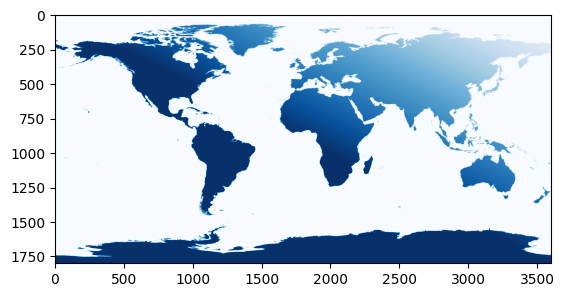

In [22]:
var_raster = rasterio.open(var_filepath)
blue = var_raster.read(1) # read first band, in this case blue_var
plt.imshow(blue, cmap='Blues');

## Access data subsetted by geographic bounding box

Using the same global coverage granule as above, we will request a bounding box subset over Australia. Harmony supports spatial subset requests within the `rangeset` query in the following structure:

`subset=lat(South:North)&subset=lon(West:East)`

More details included in the Harmony documentation:

Harmony supports the axes "lat" and "lon" for spatial subsetting, regardless of the names of those axes in the data files.  Examples:
- Subset to the lat/lon bounding box with southwest corner (-10, -10) and northeast corner (10, 10)
            subset=lat(-10:10)&subset=lon(-10:10)
- Subset to all latitudes north of -10 degrees and all longitudes west of 10 degrees
            subset=lat(-10:*)&subset=lon(*:10)
- Subset to only points with latitudes from -10 to 10 degrees, disregarding longitude
            subset=lat(-10:10)

In [23]:
bboxSubsetConfig = {
    'collection_id': harmony_collection_id,
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'granuleid': granule_id,
    'lat': '(-45.75:-9)',
    'lon': '(110:156)'
}
bbox_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?granuleid={granuleid}&subset=lat{lat}&subset=lon{lon}'.format(**bboxSubsetConfig)
print('Request URL', bbox_url)
bbox_results = submit_request(bbox_url)

Request URL https://harmony.uat.earthdata.nasa.gov/C1234088182-EEDTEST/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleid=G1234088196-EEDTEST&subset=lat(-45.75:-9)&subset=lon(110:156)


This spatially subsetted file output is downloaded to the Harmony outputs directory:

In [24]:
bbox_file_name = 'harmonybboxsubset.tif'
bbox_filepath = str(local_dir+bbox_file_name)
file_ = open(bbox_filepath, 'wb')
file_.write(bbox_results)
file_.close()

We can plot the TIF output of the subsetted file to verify our output. All bands are overlaid to plot the color composite, with this code example modified from the following source:

https://automating-gis-processes.github.io/CSC/notebooks/L5/plotting-raster.html \
© Copyright 2018, Henrikki Tenkanen \
[License](https://creativecommons.org/licenses/by-sa/4.0/)

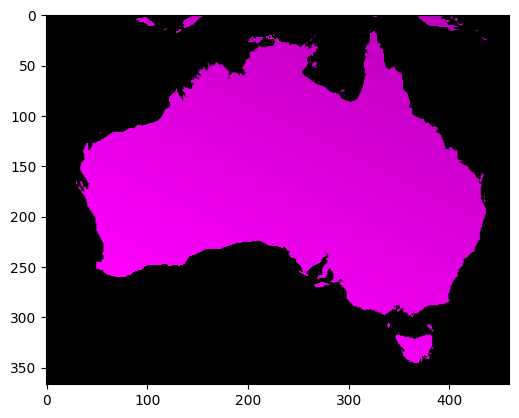

In [25]:
# Open the file:
bbox_raster = rasterio.open(bbox_filepath)

# Read the grid values into numpy arrays
red = bbox_raster.read(3)
green = bbox_raster.read(2)
blue = bbox_raster.read(1)

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    import numpy as np
    np.seterr(divide='ignore', invalid='ignore') #ignore divide by 0 error
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

# Create RGB natural color composite
rgb = np.dstack((redn, greenn, bluen))

# Let's see how our color composite looks like
plt.imshow(rgb);

## Access data filtered by temporal range

Filtering data results by temporal range is also available on this test collection. According to the Harmony API documentation, the `time` keyword within the `rangeset` query supports the following:

Either a date-time or a period string that adheres to RFC 3339. Examples:
        * A date-time: "2018-02-12T23:20:50Z" * A period: "2018-02-12T00:00:00Z/2018-03-18T12:31:12Z" or "2018-02-12T00:00:00Z/P1M6DT12H31M12S"
Only collections that have a temporal property that intersects the value of `time` are selected. If a collection has multiple temporal properties, it is the decision of the server whether only a single temporal property is used to determine the extent or all relevant temporal properties.

We will search for the following time range:

Start time: 2020-02-16 02:00:00 \
End time: 2020-02-16 03:00:00

According to [Earthdata Search](https://search.uat.earthdata.nasa.gov/search/granules?p=C1234088182-EEDTEST&pg[0][v]=f&pg[0][gsk]=-start_date&q=harmony_example&qt=2020-02-16T02%3A00%3A00.000Z%2C2020-02-16T03%3A00%3A00.000Z&tl=1567098728!4!!&lat=-66.80545903827544&long=19.313018908611213&zoom=1), a single granule `2020_02_16_ff0000_africa` is returned over this time.

In [26]:
timeSubsetConfig = {
    'collection_id': harmony_collection_id,
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'time': '("2020-02-16T02:00:00.000Z":"2020-02-16T03:00:00.000Z")'
}

time_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?&subset=time{time}'.format(**timeSubsetConfig)
print('Request URL', time_url)
time_results = submit_request(time_url)

Request URL https://harmony.uat.earthdata.nasa.gov/C1234088182-EEDTEST/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?&subset=time("2020-02-16T02:00:00.000Z":"2020-02-16T03:00:00.000Z")


This file returned over the time range of interest is downloaded to the Harmony outputs directory:

In [27]:
time_file_name = 'harmonytimesubset.tif'
time_filepath = str(local_dir+time_file_name)
file_ = open(time_filepath, 'wb')
file_.write(time_results)
file_.close()

We can plot the TIF output of this file to verify the coverage over Africa (for simplicity, plotting the first band):

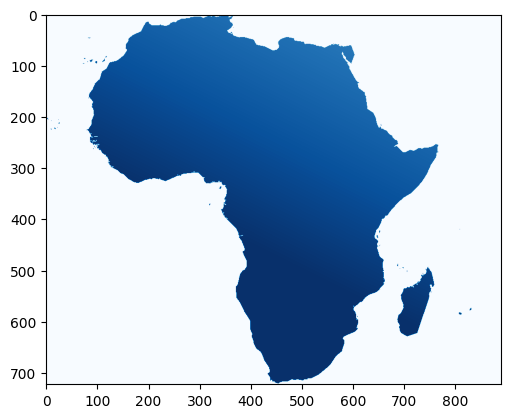

In [28]:
time_raster = rasterio.open(time_filepath)
time_band = time_raster.read(1)
plt.imshow(time_band, cmap='Blues');

## Access data subsetted by geographic shapefile
We will request data overlapping South America by uploading a shapefile with that boundary.

This requires the use of a multipart/form-data POST request. Supported shapefile formats include ESRI, GeoJSON, and KML. The associated mime-types are as follows:

| Shapefile Format | mime-type |
|:-----------------|----------:|
| ESRI | application/shapefile+zip |
| GeoJSON | application/geo+json |
| KML | application/vnd.google-earth.kml+xml |


ESRI shapefiles must be uploaded as a single .zip file.
See the Harmony documenation for more details.

Note that this request is using the shapefile for the search that it is performing to find data. It will also be used for shapefile subsetting if the service that this request is routed to supports it.

In [29]:
shapefileSubsetConfig = {
    'collection_id': harmony_collection_id,
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'blue_var,red_var,green_var',
    'format': 'image/tiff'
}

shapefile_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?format={format}'.format(**shapefileSubsetConfig)
# download the shapefile from github
shapefile_github_raw_url = 'https://raw.githubusercontent.com/nasa/harmony/main/docs/shapefiles/south_america.geojson'
shapefile_path = local_dir+'./south_america.geojson'
r = requests.get(shapefile_github_raw_url, stream=True)
with open(shapefile_path, 'wb') as fd:
    for chunk in r.iter_content(chunk_size=128):
        fd.write(chunk)

with open(shapefile_path, 'rb') as fd1:
    # the form must have a 'shapefile' key which must include the mime-type as shown. Additional parameters
    # such as temporal subsetting can be included in the form.
    multipart_form_data = {
        'shapefile': ('south_america.geojson', fd1, 'application/geo+json'),
        'subset': (None, 'time("2020-11-16T20:00:00.000Z":"2020-11-16T22:00:00.000Z")')
    }
    # submit the form using a POST request and prepare to stream the result
    if bearer_token:
        shapefile_response = requests.post(shapefile_url, files=multipart_form_data, stream=True, auth=BearerToken(bearer_token))
    else:
        shapefile_response = requests.post(shapefile_url, files=multipart_form_data, stream=True)

We can stream the result back and write it out to a file:

In [30]:
shapefile_output_filepath = str(local_dir + 'shapefile_output.tif')
with open(shapefile_output_filepath, 'wb') as fd:
    for chunk in shapefile_response.iter_content(chunk_size=128):
        fd.write(chunk)

We plot the file as before:

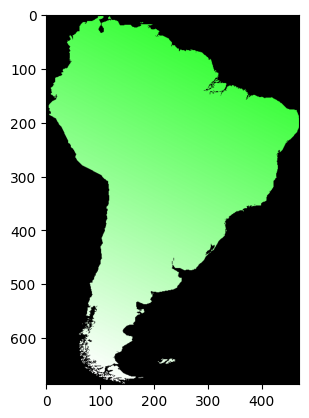

In [31]:
# Open the file:
shapefile_raster = rasterio.open(shapefile_output_filepath)

# Read the grid values into numpy arrays
red = shapefile_raster.read(3)
green = shapefile_raster.read(2)
blue = shapefile_raster.read(1)

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    import numpy as np
    np.seterr(divide='ignore', invalid='ignore') #ignore divide by 0 error
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

# Create RGB natural color composite
rgb = np.dstack((redn, greenn, bluen))

# Let's see how our color composite looks like
plt.imshow(rgb);

## Access reprojected data

The Harmony API accepts reprojection requests with a given coordinate reference system using the `outputCrs` keyword. According to the Harmony API documentation, this keyword "recognizes CRS types that can be inferred by gdal, including EPSG codes, Proj4 strings, and OGC URLs (http://www.opengis.net/def/crs/...) ". Two examples below demonstrate inputting an EPSG code and Proj4 string using the global test granule from previous examples. First, let's view the projection information of the granule in the native projection, using the variable subset example:

In [32]:
native_proj = gdal.Open(var_filepath, gdal.GA_ReadOnly)
native_proj.GetProjection()

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

Request reprojection to EPSG 6933 ("WGS 84 / NSIDC EASE-Grid 2.0 Global"):

In [33]:
epsgConfig = {
    'collection_id': harmony_collection_id,
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'granuleid': granule_id,
    'outputCrs': 'EPSG:6933',
}

epsg_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?&granuleid={granuleid}&outputCrs={outputCrs}'.format(**epsgConfig)
print('Request URL', epsg_url)
epsg_results = submit_request(epsg_url)

Request URL https://harmony.uat.earthdata.nasa.gov/C1234088182-EEDTEST/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?&granuleid=G1234088196-EEDTEST&outputCrs=EPSG:6933


This reprojected output is downloaded to the Harmony outputs directory and the projection information can be viewed using GDAL:

In [34]:
epsg_file_name = 'harmonyepsg.tif'
epsg_filepath = str(local_dir+epsg_file_name)
file_ = open(epsg_filepath, 'wb')
file_.write(epsg_results)
file_.close()

# get projection information
epsg = gdal.Open(epsg_filepath, gdal.GA_ReadOnly)
epsg.GetProjection()

'PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Cylindrical_Equal_Area"],PARAMETER["standard_parallel_1",30],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

We can see that the output was reprojected to Cylindrical Equal Area as expected. We can do a visual check of this as well:

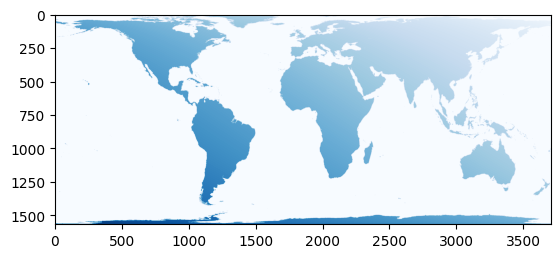

In [35]:
epsg_raster = rasterio.open(epsg_filepath)
epsg_band = epsg_raster.read(1)
plt.imshow(epsg_band, cmap='Blues');

Reprojection can also be requested using a proj4 string. You must ensure that the proper URL encoding is included in the request so that proj4 string spaces and special characters are handled without error:

In [36]:
# URL encode string using urllib parse package
proj_string = '+proj=cea +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs' # proj4 of WGS 84 / NSIDC EASE-Grid 2.0 Global projection
proj_encode = parse.quote(proj_string)

projConfig = {
    'collection_id': harmony_collection_id,
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'granuleid': granule_id,
    'outputCrs': proj_encode
}

proj_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?&granuleid={granuleid}&outputCrs={outputCrs}'.format(**projConfig)
print('Request URL', proj_url)
proj_results = submit_request(proj_url)

Request URL https://harmony.uat.earthdata.nasa.gov/C1234088182-EEDTEST/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?&granuleid=G1234088196-EEDTEST&outputCrs=%2Bproj%3Dcea%20%2Blon_0%3D0%20%2Blat_ts%3D30%20%2Bx_0%3D0%20%2By_0%3D0%20%2Bellps%3DWGS84%20%2Btowgs84%3D0%2C0%2C0%2C0%2C0%2C0%2C0%20%2Bunits%3Dm%20%2Bno_defs


This reprojected output is downloaded to a directory with write permissions and the projection information can be viewed using GDAL. The projection is equivalent to the specified EPSG request above as expected:

In [37]:
proj_file_name = 'harmonyproj4.tif'
proj_filepath = str(local_dir+proj_file_name)
file_ = open(proj_filepath, 'wb')
file_.write(proj_results)
file_.close()

# get projection information
proj = gdal.Open(proj_filepath, gdal.GA_ReadOnly)
proj.GetProjection()

'PROJCS["unknown",GEOGCS["unknown",DATUM["Unknown based on WGS 84 ellipsoid using towgs84=0,0,0,0,0,0,0",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Cylindrical_Equal_Area"],PARAMETER["standard_parallel_1",30],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

## Access Level 2 swath regridded data

Moving outside of the `harmony/gdal` service, we will now request regridding from the `Swath Projector` service using the `C1233860183-EEDTEST`, or Harmony L2 swath example, collection provided in NetCDF format.


The Harmony API accepts several query parameters related to regridding and interpolation in addition to the reprojection parameters above:

`interpolation=<String>` - Both `near` and `bilinear` are valid options

`scaleSize=x,y` - 2 comma separated numbers as floats

`scaleExtent=xmin,ymin,xmax,ymax` - 4 comma separated numbers as floats

`width=<Float>`  

`height=<Float>`

An error is returned if both `scaleSize` and `width`/`height` parameters are both provided (only one or the other can be used).

Request reprojection to [Europe Lambert Conformal Conic](https://epsg.io/102014) with a new scale extent and nearest neighbor interpolation:

In [38]:
# URL encode string using urllib parse package
l2proj_string = '+proj=lcc +lat_1=43 +lat_2=62 +lat_0=30 +lon_0=10 +x_0=0 +y_0=0 +ellps=intl +units=m +no_defs'
l2proj_encode = parse.quote(l2proj_string)


regridConfig = {
    'l2collection_id': 'C1233860183-EEDTEST',
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'granuleid': 'G1233860486-EEDTEST',
    'outputCrs': l2proj_encode,
    'interpolation': 'near',
    'scaleExtent': '-7000000,1000000,8000000,8000000'
}

regrid_url = harmony_root+'/{l2collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?&granuleid={granuleid}&outputCrs={outputCrs}&interpolation={interpolation}&scaleExtent={scaleExtent}'.format(**regridConfig)
print('Request URL', regrid_url)
regrid_results = submit_request(regrid_url)

Request URL https://harmony.uat.earthdata.nasa.gov/C1233860183-EEDTEST/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?&granuleid=G1233860486-EEDTEST&outputCrs=%2Bproj%3Dlcc%20%2Blat_1%3D43%20%2Blat_2%3D62%20%2Blat_0%3D30%20%2Blon_0%3D10%20%2Bx_0%3D0%20%2By_0%3D0%20%2Bellps%3Dintl%20%2Bunits%3Dm%20%2Bno_defs&interpolation=near&scaleExtent=-7000000,1000000,8000000,8000000


This reprojected and regridded output is downloaded to the Harmony outputs directory and we can inspect a variable to check for projection and grid dimension:

In [39]:
regrid_file_name = 'regrid.nc'
regrid_filepath = str(local_dir+regrid_file_name)
file_ = open(regrid_filepath, 'wb')
file_.write(regrid_results)
file_.close()

# Inspect dimensions of the blue_var:
regrid_nc = Dataset(regrid_filepath)
print(regrid_nc.variables.keys())
blue_var = regrid_nc.variables['blue_var']
print(blue_var)

dict_keys(['time', 'red_var', 'lambert_conformal_conic', 'y', 'x', 'alpha_var', 'green_var', 'blue_var'])
<class 'netCDF4.Variable'>
uint8 blue_var(time, y, x)
    _FillValue: 0
    add_offset: 28
    scale_factor: 2
    grid_mapping: lambert_conformal_conic
unlimited dimensions: 
current shape = (1, 626, 1341)
filling on


Print the x and y dimensions to confirm that the output matches the requested scale extent in meters:

In [40]:
x = regrid_nc.variables['x']
y = regrid_nc.variables['y']
print('min x', min(x), 'max x', max(x))
print('min y', min(y), 'max y', max(y))

min x -6994407.158836689 max x 7994407.158836689
min y 1005591.054313099 max y 7994408.945686901


## Access multiple files from an asynchronous request

By default, a request resulting in more than one file will be returned asynchronously via a Job URL. The initial request submission is automatically redirected to this URL, and output links are appended to the response as they complete. The following query should return three granules based on the following temporal range:

In [41]:
asyncConfig = {
    'collection_id': harmony_collection_id,
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'time': '("2020-01-16T02:00:00.000Z":"2020-02-16T07:00:00.000Z")',
    'maxResults': 3
}

async_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?&subset=time{time}&maxResults={maxResults}'.format(**asyncConfig)
print('Request URL', async_url)
async_json = get_json_response(async_url)
pprint.pprint(async_json)

Request URL https://harmony.uat.earthdata.nasa.gov/C1234088182-EEDTEST/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?&subset=time("2020-01-16T02:00:00.000Z":"2020-02-16T07:00:00.000Z")&maxResults=3
{'createdAt': '2024-11-19T06:37:02.988Z',
 'dataExpiration': '2024-12-19T06:37:02.988Z',
 'jobID': '6291401f-aa92-4f09-8fc7-1d6d4faec72c',
 'labels': [],
 'links': [{'href': 'https://harmony.uat.earthdata.nasa.gov/jobs/6291401f-aa92-4f09-8fc7-1d6d4faec72c/cancel',
            'rel': 'canceler',
            'title': 'Cancels the job.',
            'type': 'application/json'},
           {'href': 'https://harmony.uat.earthdata.nasa.gov/jobs/6291401f-aa92-4f09-8fc7-1d6d4faec72c/pause',
            'rel': 'pauser',
            'title': 'Pauses the job.',
            'type': 'application/json'},
           {'href': 'https://harmony.uat.earthdata.nasa.gov/jobs/6291401f-aa92-4f09-8fc7-1d6d4faec72c?page=1&limit=2000',
            'rel': 'self',
            'title': 'The current page',
  

The async response initially shows 0% progress. The initial request URL will automatically redirect to a job URL, which we can manually determine using the jobID:

In [42]:
jobConfig = {
    'jobID': async_json['jobID']
}

job_url = harmony_root+'/jobs/{jobID}'.format(**jobConfig)
print('Job URL', job_url)

Job URL https://harmony.uat.earthdata.nasa.gov/jobs/6291401f-aa92-4f09-8fc7-1d6d4faec72c


The `links` list in the job response will continue to be updated as outputs are produced:

In [43]:
job_json = get_json_response(job_url)

print('Job response:')
print()
pprint.pprint(job_json)

Job response:

{'createdAt': '2024-11-19T06:37:02.988Z',
 'dataExpiration': '2024-12-19T06:37:02.988Z',
 'jobID': '6291401f-aa92-4f09-8fc7-1d6d4faec72c',
 'labels': [],
 'links': [{'href': 'https://harmony.uat.earthdata.nasa.gov/jobs/6291401f-aa92-4f09-8fc7-1d6d4faec72c/cancel',
            'rel': 'canceler',
            'title': 'Cancels the job.',
            'type': 'application/json'},
           {'href': 'https://harmony.uat.earthdata.nasa.gov/jobs/6291401f-aa92-4f09-8fc7-1d6d4faec72c/pause',
            'rel': 'pauser',
            'title': 'Pauses the job.',
            'type': 'application/json'},
           {'bbox': [-25.4, -34.9, 63.5, 37.4],
            'href': 'https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/6291401f-aa92-4f09-8fc7-1d6d4faec72c/4907885/2020_02_01_7f00ff_africa.tif',
            'rel': 'data',
            'temporal': {'end': '2020-02-01T23:59:59.000Z',
                         'start': '2020-02-01T00:00:00.000Z'},
          

A loop can be set up to query the job status and download outputs once the job is complete:

In [44]:
#Continue loop while request is still processing
while job_json['status'] == 'running' and job_json['progress'] < 100:
    print('Job status is running. Progress is ', job_json['progress'], '%. Trying again.')
    time.sleep(10)
    job_json = get_json_response(job_url)
    if job_json['status'] == 'running':
        continue

if job_json['status'] == 'successful' and job_json['progress'] == 100:
    print('Job progress is 100%. Output links printed below:')
    links = [link for link in job_json['links'] if link.get('rel', 'data') == 'data'] #list of data links from response
    for i in range(len(links)):
        link_dict = links[i]
        print(link_dict['href'])
        output_file_name = str(link_dict['title']+'.tif')
        proj_filepath = str(local_dir+output_file_name)
        file_ = open(proj_filepath, 'wb')
        file_.write(proj_results)
        file_.close()

Job status is running. Progress is  69 %. Trying again.
Job progress is 100%. Output links printed below:
https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/6291401f-aa92-4f09-8fc7-1d6d4faec72c/4907885/2020_02_01_7f00ff_africa.tif
https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/6291401f-aa92-4f09-8fc7-1d6d4faec72c/4907884/2020_01_16_ff0000_global.tif
https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/6291401f-aa92-4f09-8fc7-1d6d4faec72c/4907886/2020_02_02_3200ff_africa.tif


## Previewing a small number of results

By default, a request will return as many results as match the spatial and temporal query parameters, although this is subject to system limitations to prevent users from inadvertently overwhelming the system.  If a user wishes to further limit the number of results returned in order to preview a small number of results before requesting a larger transformation, they can simply supply a parameter called 'maxResults'.

In [45]:
asyncConfig = {
    'collection_id': harmony_collection_id,
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'maxResults': '2'
}

async_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?&maxResults={maxResults}'.format(**asyncConfig)
print('Request URL', async_url)
async_json = get_json_response(async_url)
pprint.pprint(async_json)

Request URL https://harmony.uat.earthdata.nasa.gov/C1234088182-EEDTEST/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?&maxResults=2
{'createdAt': '2024-11-19T06:37:28.743Z',
 'dataExpiration': '2024-12-19T06:37:28.743Z',
 'jobID': 'b7dd6475-34ff-4661-b15b-f7e6934236d9',
 'labels': [],
 'links': [{'href': 'https://harmony.uat.earthdata.nasa.gov/jobs/b7dd6475-34ff-4661-b15b-f7e6934236d9/cancel',
            'rel': 'canceler',
            'title': 'Cancels the job.',
            'type': 'application/json'},
           {'href': 'https://harmony.uat.earthdata.nasa.gov/jobs/b7dd6475-34ff-4661-b15b-f7e6934236d9/pause',
            'rel': 'pauser',
            'title': 'Pauses the job.',
            'type': 'application/json'},
           {'href': 'https://harmony.uat.earthdata.nasa.gov/jobs/b7dd6475-34ff-4661-b15b-f7e6934236d9?page=1&limit=2000',
            'rel': 'self',
            'title': 'The current page',
            'type': 'application/json'}],
 'message': 'CMR query iden

## Access WMS Map Image

Harmony supports WMS requests, producing geo-registered map images, for all collections associated to a given Harmony transformation service. The following steps were adapted from the [ORNL DAAC help document](https://webmap.ornl.gov/ogc/help/wms_script_python.html) on interacting with a WMS service in Python, using the example harmony collection.

In [46]:
wmsConfig = {
    'collection_id': 'C1233800302-EEDTEST',
    'service': 'WMS',
    'version': '1.3.0',
    'request': 'GetCapabilities',
}

wms_url = harmony_root+'/{collection_id}/wms?service={service}&version={version}&request={request}'.format(**wmsConfig)
print('Request URL', wms_url)

Request URL https://harmony.uat.earthdata.nasa.gov/C1233800302-EEDTEST/wms?service=WMS&version=1.3.0&request=GetCapabilities


Information on the WMS service contents and titles of each variable layer:

In [47]:
if bearer_token:
    wms_auth = Authentication(auth_delegate = BearerToken(bearer_token))
    wms = WebMapService(wms_url, auth=wms_auth)
else:
    wms = WebMapService(wms_url)
print(wms.identification.title)

[op.name for op in wms.operations]

Harmony WMS Service


['GetCapabilities', 'GetMap', 'GetFeatureInfo']

In [48]:
contents = list(wms.contents)
print ('Variable contents:')
contents

Variable contents:


['C1233800302-EEDTEST/V1233801717-EEDTEST',
 'C1233800302-EEDTEST/V1233801716-EEDTEST',
 'C1233800302-EEDTEST/V1233801696-EEDTEST',
 'C1233800302-EEDTEST/V1233801695-EEDTEST']

In [49]:
print('Variable titles:')
[wms[contents[i]].title for i in range(len(contents))]

Variable titles:


['alpha_var (Alpha channel )',
 'blue_var (Blue channel)',
 'green_var (Green channel)',
 'red_var (Red Channel)']

Select Coherence layer and send request:

In [50]:
coh = contents[1] # Coherence layer

# send the request
img = wms.getmap(
    layers=[coh],
    version='1.3.0',
    CRS='CRS:84',
    styles=['default'],
    bbox=(-180,-90,154.4170924291685765,90), # Return full extent
#    bbox=(-121.6,37.2,-120.57,38.0), # Example of a subset over California
    granuleId='G1233800343-EEDTEST', # pick only one granule so the request won't time out
    size=(600, 300),
    format='image/png',
    transparent=True)

The image file is downloaded to the Harmony outputs directory:

In [51]:
# save image in a local file
img_name = '/coh.png'
img_path = str(local_dir+img_name)
out = open(img_path, 'wb')
out.write(img.read())
out.close()

Read and plot the Coherence layer image:

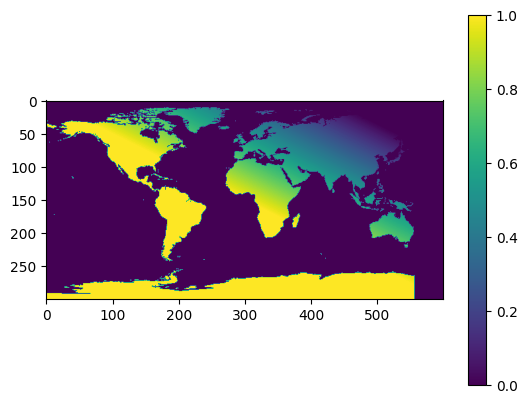

In [52]:
# read png image file
im = mpimg.imread(img_path)

# show image
plt.imshow(im)
plt.colorbar();

## Direct Delivery of Results to a User's S3 Bucket

Harmony result data can be delivered directly to a user's S3 bucket (at the root level or optionally to a specific folder). To allow Harmony to write to the bucket and to make the data readable to the user once it has been written requires the following:

1. The bucket must be in the same AWS region as Harmony, `us-west-2`.
2. The bucket must either disable access control lists (ACL) or set the ownership rules so that the bucket owner owns written objects (not the object writer). Otherwise the files written by Harmony will not be accessible to the user.
3. A bucket policy must be attached to the bucket to allow Harmony to interact with it. The policy should enable the `s3:PutObject` and `s3:GetBucketLocation` actions.

To facilitate step 3, Harmony provides an endpoint that can generate an appropriate bucket policy given a bucket name. The generated policy will only work for the Harmony environment from which it is generated.

In [53]:
bucket_name = 'my-bucket'
parameters = { 'bucketPath': bucket_name }
query_string = parse.urlencode( parameters )
bucket_policy_url = harmony_root+'/staging-bucket-policy?' + query_string

policy_response = request.urlopen(bucket_policy_url)
print(json.dumps(json.loads(policy_response.read().decode('utf-8')), indent=2))

{
  "Version": "2012-10-17",
  "Statement": [
    {
      "Sid": "write permission",
      "Effect": "Allow",
      "Principal": {
        "AWS": "arn:aws:iam::549360732797:root"
      },
      "Action": "s3:PutObject",
      "Resource": "arn:aws:s3:::my-bucket/*"
    },
    {
      "Sid": "get bucket location permission",
      "Effect": "Allow",
      "Principal": {
        "AWS": "arn:aws:iam::549360732797:root"
      },
      "Action": "s3:GetBucketLocation",
      "Resource": "arn:aws:s3:::my-bucket"
    }
  ]
}


`bucketPath` above can be a full S3 url, just a bucket name, or bucket name + key. All of the following are valid
* `s3://my-bucket`
* `s3://my-bucket/some/path`
* `my-bucket`
* `my-bucket/some/other/path`